In [3]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.time import Time

In [17]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fs = 14

In [8]:
# ISGRI: 15 - 30 keV
cr1, vr1, sg1, xp1, acr1, avr1, cr1_cpsf, cr1_psf, err1_cpsf, err1_psf, date1, offset1 = loadJupiterIMG(path='../data/Jupiter/15-30keV/Images', scw_path='../data/jupiter_table.dat', fitting=False)

# ISGRI: 30 - 60 keV
cr2, vr2, sg2, xp2, acr2, avr2, cr2_cpsf, cr2_psf, err2_cpsf, err2_psf, date2, offset2 = loadJupiterIMG(path='../data/Jupiter/30-60keV/Images', scw_path='../data/jupiter_table.dat', fitting=False)

# ISGRI: 15 - 30 keV
cr3, vr3, sg3, xp3, acr3, avr3, cr3_cpsf, cr3_psf, err3_cpsf, err3_psf, date3, offset3 = loadJupiterIMG(path='../data/Jupiter/3-15keV/Images', scw_path='../data/jupiter_table.dat', jemx = True, fitting=False)

Error processing file 059900370010.001mosaic.fits: list index out of range
Error processing file 026800190010.001mosaic.fits: list index out of range
Error processing file 026800250010.001mosaic.fits: list index out of range
Error processing file 027300140010.001mosaic.fits: list index out of range
Error processing file 027300090010.001mosaic.fits: list index out of range
Error processing file 027300100010.001mosaic.fits: list index out of range
Error processing file 060000450010.001mosaic.fits: list index out of range
Error processing file 059600530010.001mosaic.fits: list index out of range
Error processing file 059500130010.001mosaic.fits: list index out of range
Error processing file 059500510010.001mosaic.fits: list index out of range
Error processing file 026700380010.001mosaic.fits: list index out of range
Error processing file 060400120010.001mosaic.fits: list index out of range
Error processing file 027200380010.001mosaic.fits: list index out of range
Error processing file 059

In [9]:
data = np.genfromtxt('../data/weighted_crab_averages.txt', delimiter='\t', skip_header=1, dtype=None, encoding=None)

crabENERGY = data['f0']  # Energy Band strings
crabYEAR = data['f1'].astype(int)
crabCR = data['f2'].astype(float)
crabERR = data['f3'].astype(float)

### Distribution of useful ScWs with time ranges from literature

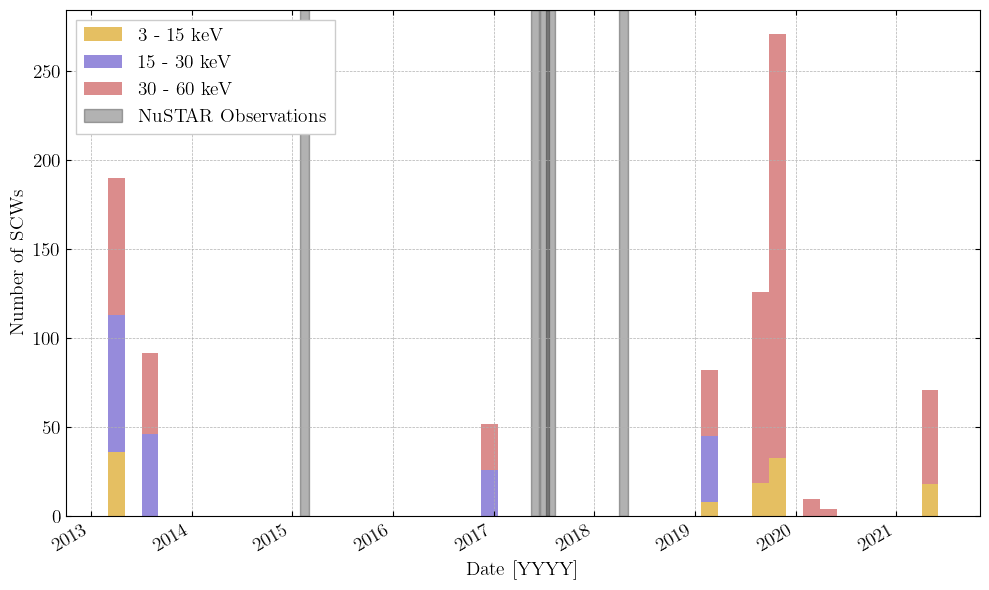

In [10]:
plot_scw_distribution(date1, date2, date3)

### 15 - 30 keV

Light curves

In [11]:
img_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in date1]

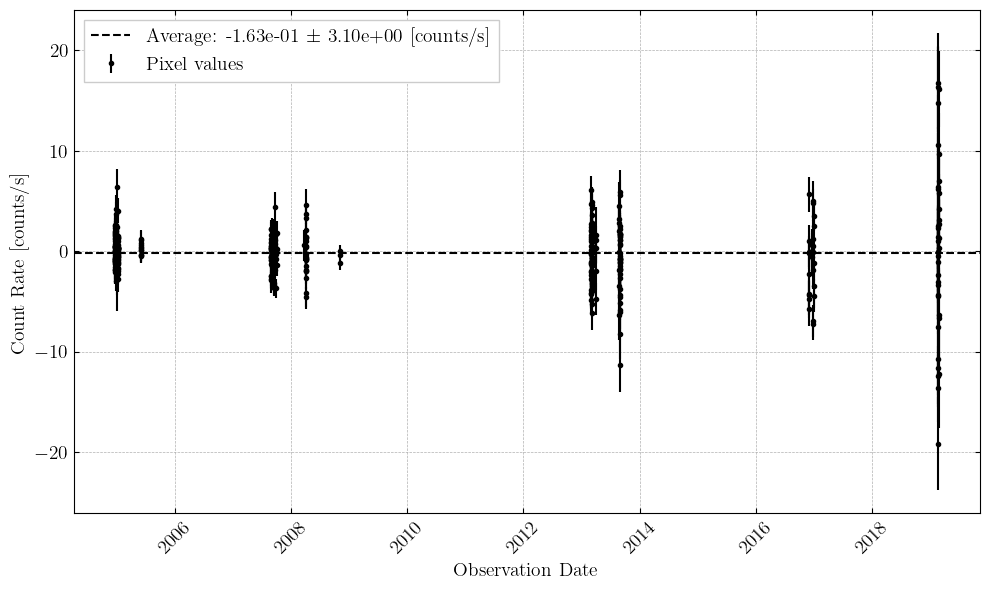

In [12]:
plot_countrate(img_times1, cr1, vr1)

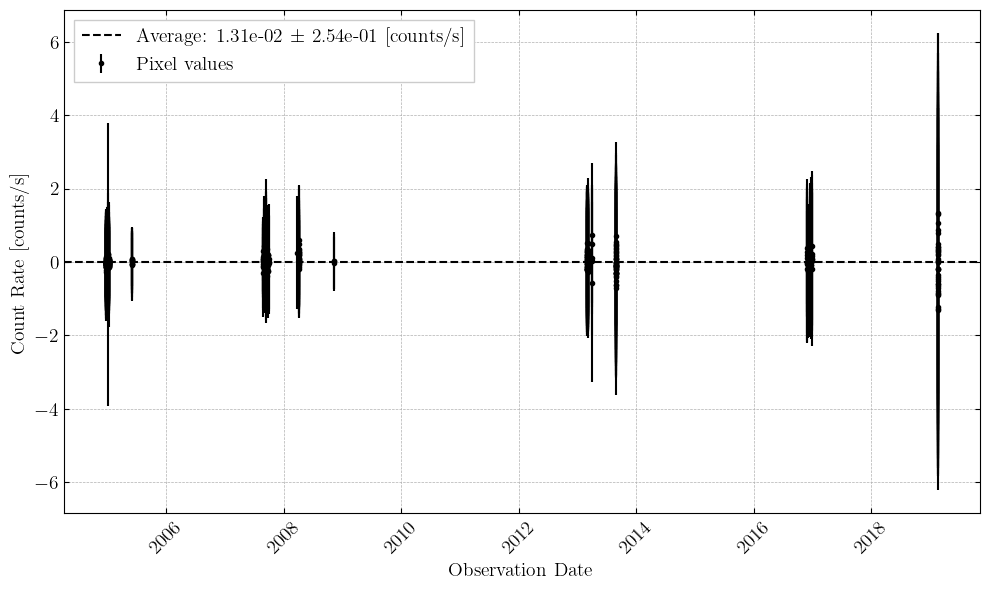

In [13]:
plot_countrate(img_times1, acr1, avr1)

Signal to noise ratio

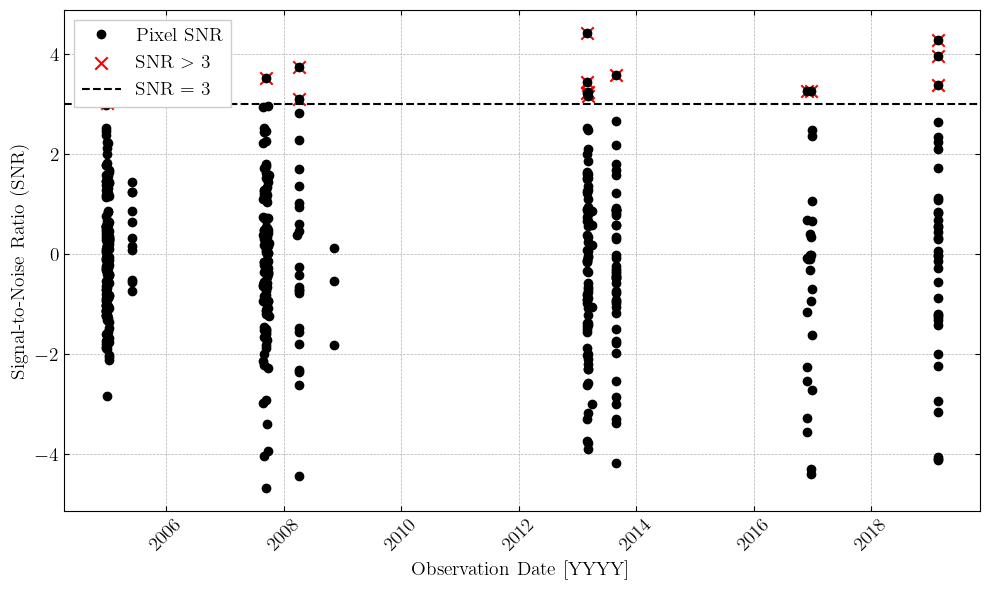

In [14]:
plot_snr(img_times1, cr1, vr1)

Total points: 503
Observed points |SNR| > 3: 42
Expected points |SNR| > 3: 1.36
Observed fraction: 8.35%
Expected fraction: 0.27%
P-value (|SNR| > 3): 1.387e-47

Observed points SNR > 3: 21
Expected points SNR > 3: 0.68
Observed fraction (positive only): 4.17%
Expected fraction: 0.135%
P-value (SNR > 3): 2.032e-24


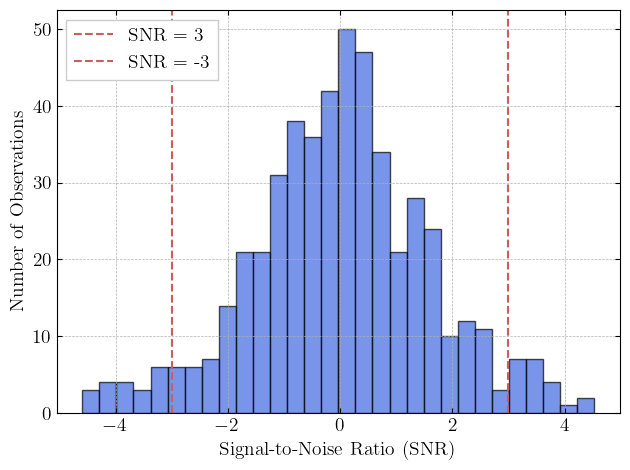

In [15]:
plot_snr_distribution(cr1, vr1, color='royalblue')

Fluxes

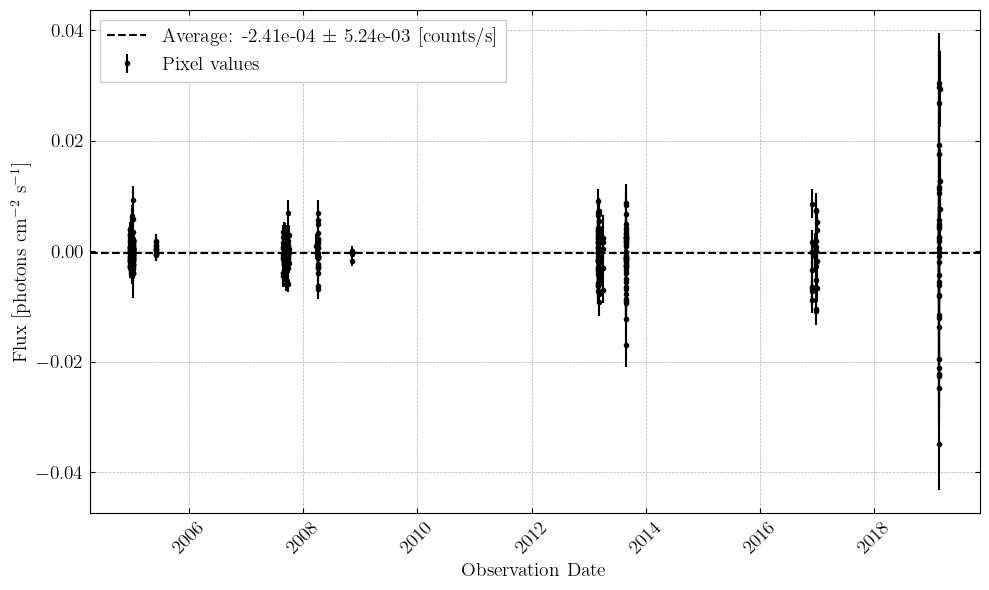

In [31]:
mask = crabENERGY == "15-30 keV"
crabYEAR_15_30 = crabYEAR[mask]
crabCR_15_30 = crabCR[mask]
crabERR_15_30 = crabERR[mask]

ph_flux1, ph_flux1_err, erg_flux1, erg_flux1_err, flux1_date = cr2flux(cr1, vr1, img_times1, crabCR_15_30, crabERR_15_30, crabYEAR_15_30)

plot_flux(flux1_date, ph_flux1, ph_flux1_err**2)

In [23]:
ph_flux_weighted_avg, ph_flux_weighted_err = simple_weighted_average(ph_flux1, ph_flux1_err)
print(f"Weighted Photon Flux: {ph_flux_weighted_avg:.3e} ± {ph_flux_weighted_err:.3e}") 

Weighted Photon Flux: -7.942e-05 ± 1.012e-04


In [27]:
snr = cr1 / np.sqrt(vr1)
outliers_idx = [i for i, snr in enumerate(snr) if snr > 3]

print(f'Persistent upper limit: {ph_flux_weighted_err * 3 + ph_flux_weighted_avg:.3e}') # photons/cm2/s (3 * sigma weighted error + weighted average)
print(f'Average errorbar * 3: {ph_flux1_err.mean() * 3:.3e}') # photons/cm2/s (3 * sigma average error)
print(f'Max upper limit: {np.max([flux for i, flux in enumerate(ph_flux1) if i in outliers_idx]):.3e}') # photons/cm2/s (maximum flux value with S/N > 3)

Persistent upper limit: 2.241e-04
Average errorbar * 3: 7.271e+00
Max upper limit: 3.224e+01


In [28]:
cr1[outliers_idx].mean() # upper limit countrate sporadic (per scw)
cr1[outliers_idx].mean()/170 * 1e-8 # in terms of crab erg flux

3.8529405017304264e-10

In [29]:
gamma = 2.13  # photon index of ISGRI 
E0 = 100  # 100 keV reference energy
K = 6.5e-4  # flux (photons/cm2/s) @ 100 keV 

energy_range = (15, 30)  # keV

E = np.linspace(energy_range[0], energy_range[1], 1000) 

power_law = K * (E / E0) ** (-gamma)  # flux
flux = np.trapz(power_law * E * 1.6e-9, E)  # integrate over the energy range
print(flux)

8.82159173716615e-09


Monthly weighted average

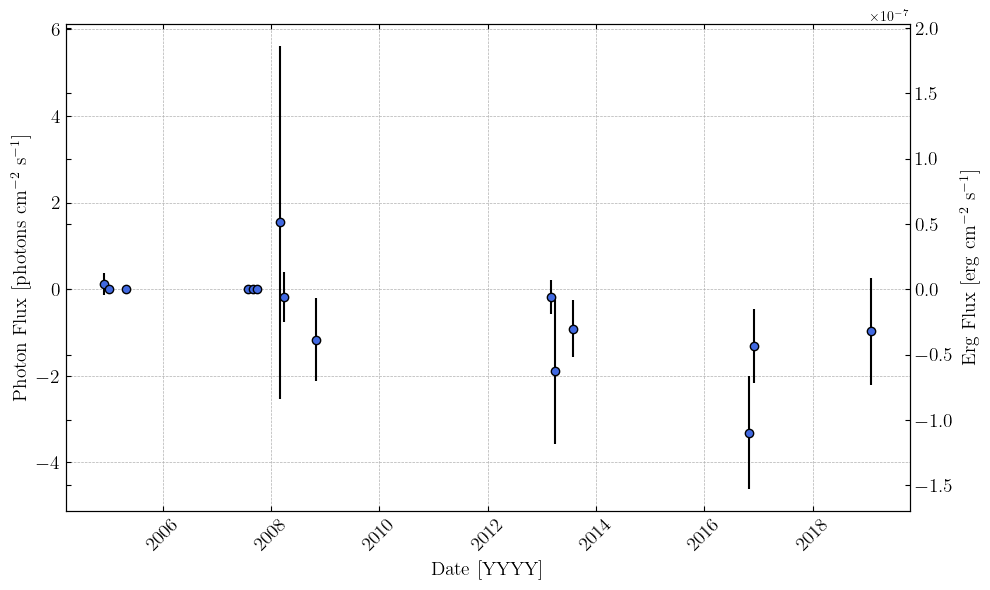

In [19]:
monthly_lightcurve = plot_monthly_flux_lc(ph_flux1, ph_flux1_err, erg_flux1, erg_flux1_err, flux1_date, plot=True)

Comparison with background

Images corresponding to S/N > 3:
Date: 2019-02-23 15:51:50, S/N: 3.0572524514730124
File name: 215100690010.001mosaic.fits
Max value: 17.706110458837227
Index of max value: 352



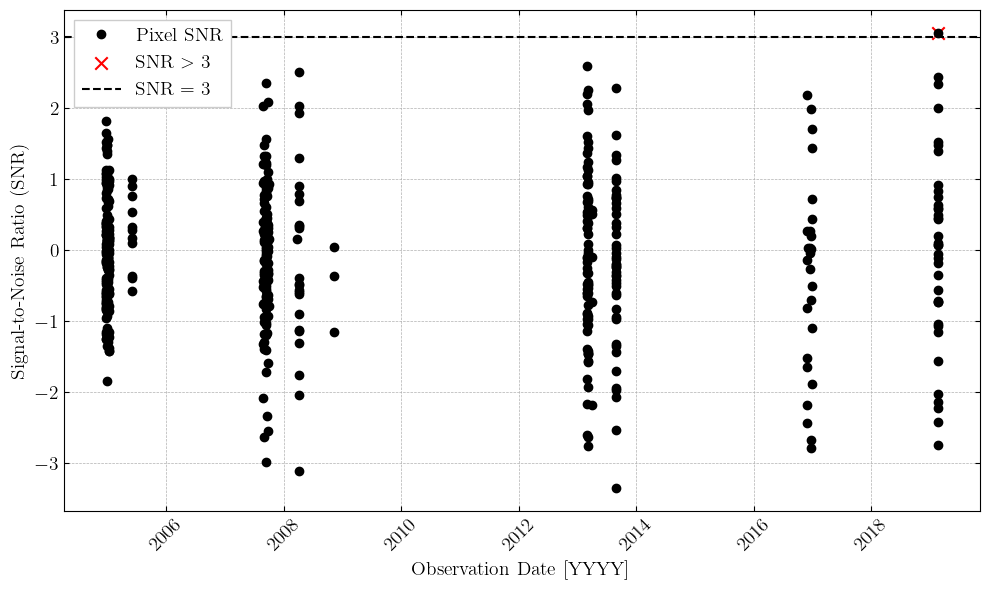

In [25]:
plot_bkgd_snr(img_times1, cr1, vr1, acr1, avr1)

Total points: 503
Observed points |SNR| > 3: 3
Expected points |SNR| > 3: 1.36
Observed fraction: 0.60%
Expected fraction: 0.27%
P-value (|SNR| > 3): 1.563e-01

Observed points SNR > 3: 1
Expected points SNR > 3: 0.68
Observed fraction (positive only): 0.20%
Expected fraction: 0.135%
P-value (SNR > 3): 4.931e-01


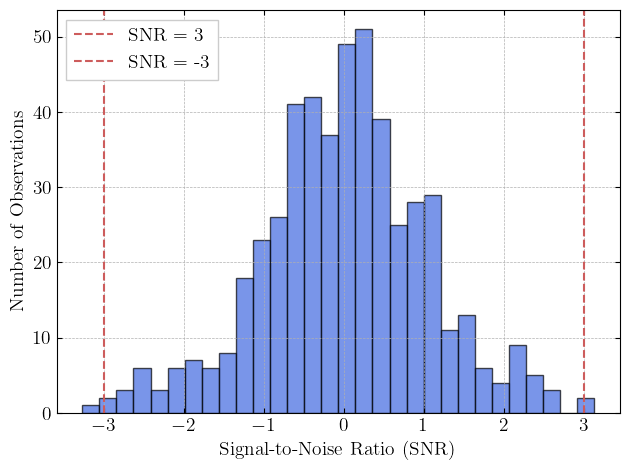

In [22]:
plot_bkgd_snr_distribution(cr1, vr1, acr1, avr1)

### 30 - 60 keV

Light curves

In [26]:
img_times2 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in date2]

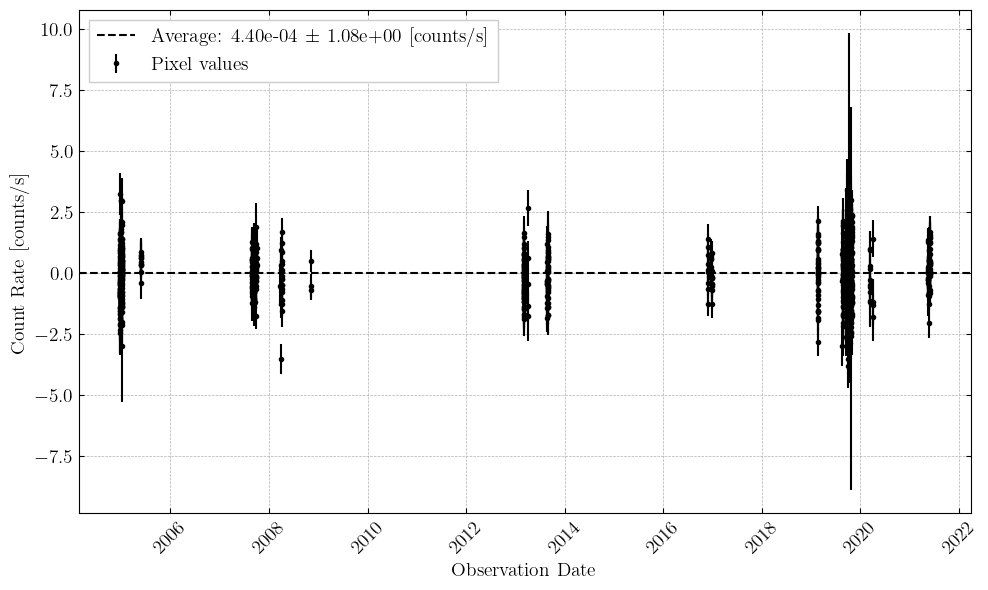

In [27]:
plot_countrate(img_times2, cr2, vr2)

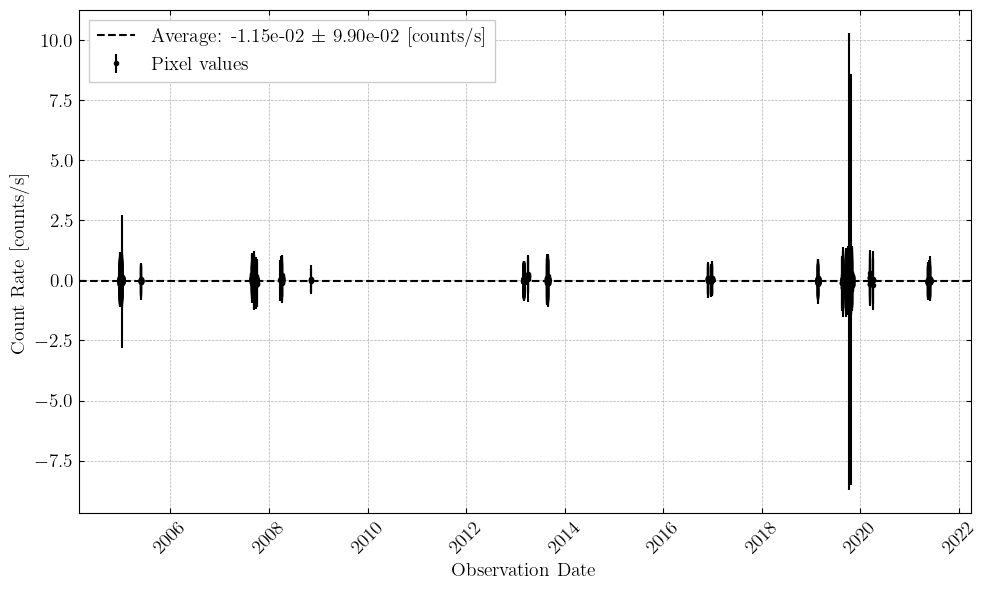

In [28]:
plot_countrate(img_times2, acr2, avr2)

Signal to noise ratio

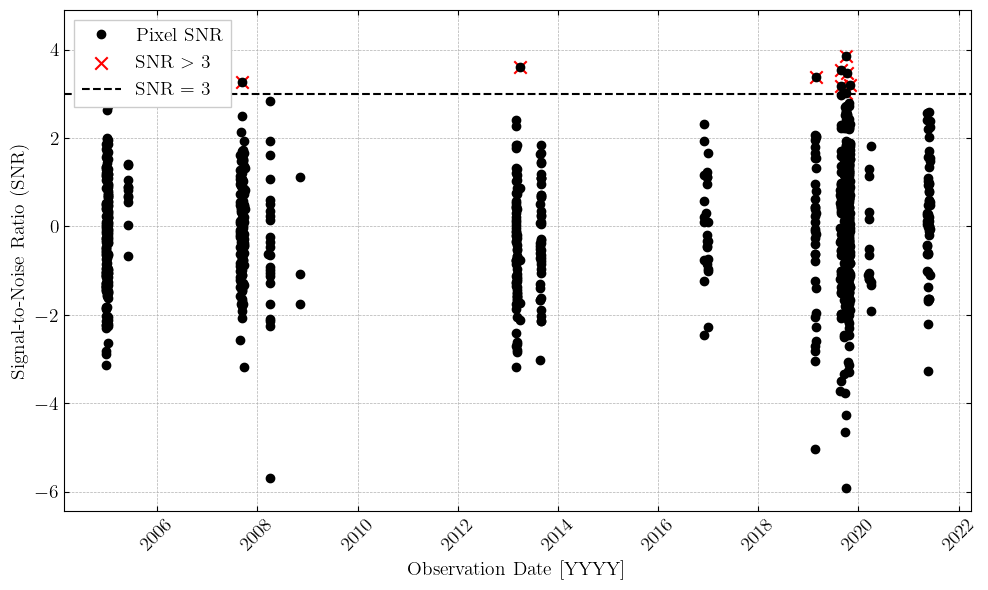

In [29]:
plot_snr(img_times2, cr2, vr2)

Total points: 915
Observed points |SNR| > 3: 33
Expected points |SNR| > 3: 2.47
Observed fraction: 3.61%
Expected fraction: 0.27%
P-value (|SNR| > 3): 5.828e-26

Observed points SNR > 3: 15
Expected points SNR > 3: 1.24
Observed fraction (positive only): 1.64%
Expected fraction: 0.135%
P-value (SNR > 3): 5.198e-12


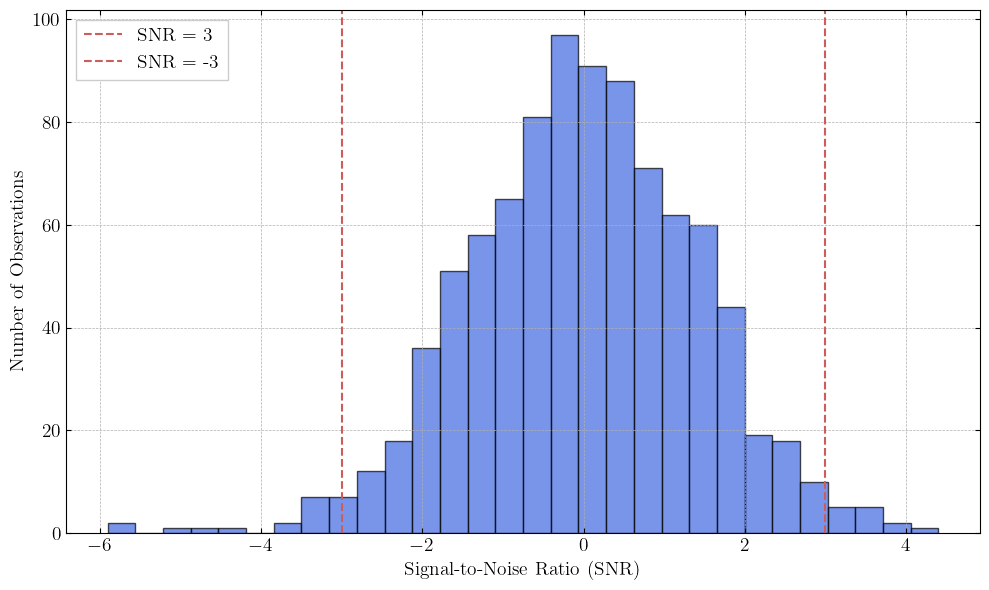

In [30]:
plot_snr_distribution(cr2, vr2, color='royalblue')

Fluxes

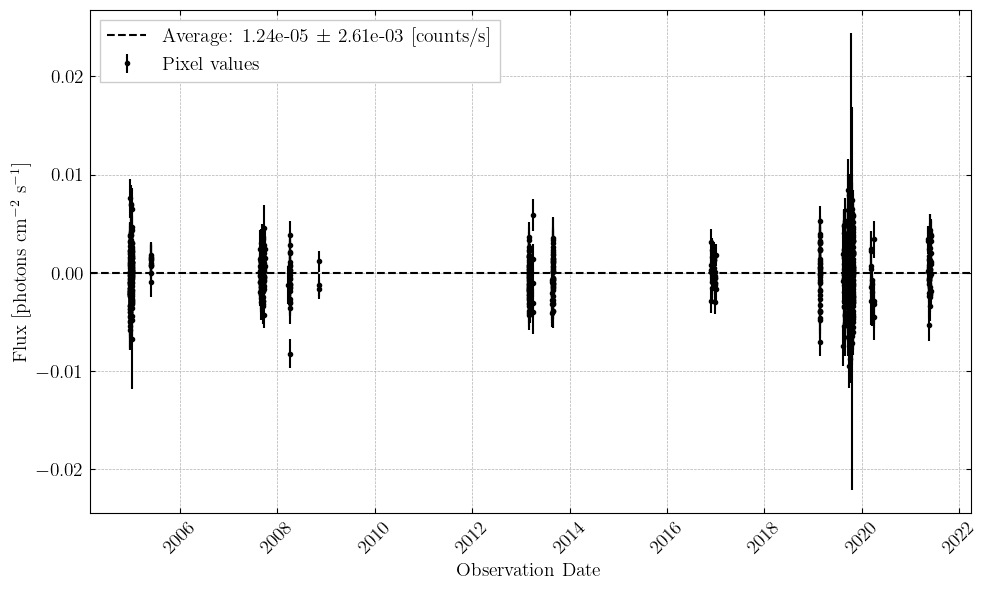

In [33]:
mask = crabENERGY == "30-60 keV"
crabYEAR_30_60 = crabYEAR[mask]
crabCR_30_60 = crabCR[mask]
crabERR_30_60 = crabERR[mask]

ph_flux2, ph_flux2_err, erg_flux2, erg_flux2_err, flux2_date = cr2flux(cr2, vr2, img_times2, crabCR_30_60, crabERR_30_60, crabYEAR_30_60)

plot_flux(flux2_date, ph_flux2, ph_flux2_err**2)

In [34]:
ph_flux_weighted_avg, ph_flux_weighted_err = simple_weighted_average(ph_flux2, ph_flux2_err)
print(f"Weighted Photon Flux: {ph_flux_weighted_avg:.3e} ± {ph_flux_weighted_err:.3e}") 

Weighted Photon Flux: -7.668e-05 ± 5.545e-05


In [36]:
snr = cr2 / np.sqrt(vr2)
outliers_idx = [i for i, snr in enumerate(snr) if snr > 3]

print(f'Persistent upper limit: {ph_flux_weighted_err * 3 + ph_flux_weighted_avg:.3e}') # photons/cm2/s (3 * sigma weighted error + weighted average)
print(f'Average errorbar * 3: {ph_flux1_err.mean() * 3:.3e}') # photons/cm2/s (3 * sigma average error)
print(f'Max upper limit: {np.max([flux for i, flux in enumerate(ph_flux2) if i in outliers_idx]):.3e}') # photons/cm2/s (maximum flux value with S/N > 3)

Persistent upper limit: 8.966e-05
Average errorbar * 3: 6.822e-03
Max upper limit: 7.960e-03


In [37]:
cr2[outliers_idx].mean() # upper limit countrate sporadic (per scw)
cr2[outliers_idx].mean()/170 * 1e-8 # in terms of crab erg flux

1.47271224815921e-10

In [38]:
gamma = 2.13  # photon index of ISGRI 
E0 = 100  # 100 keV reference energy
K = 6.5e-4  # flux (photons/cm2/s) @ 100 keV 

energy_range = (30, 60)  # keV

E = np.linspace(energy_range[0], energy_range[1], 1000) 

power_law = K * (E / E0) ** (-gamma)  # flux
flux = np.trapz(power_law * E * 1.6e-9, E)  # integrate over the energy range
print(flux)

8.06144797050624e-09


Monthly weighted average

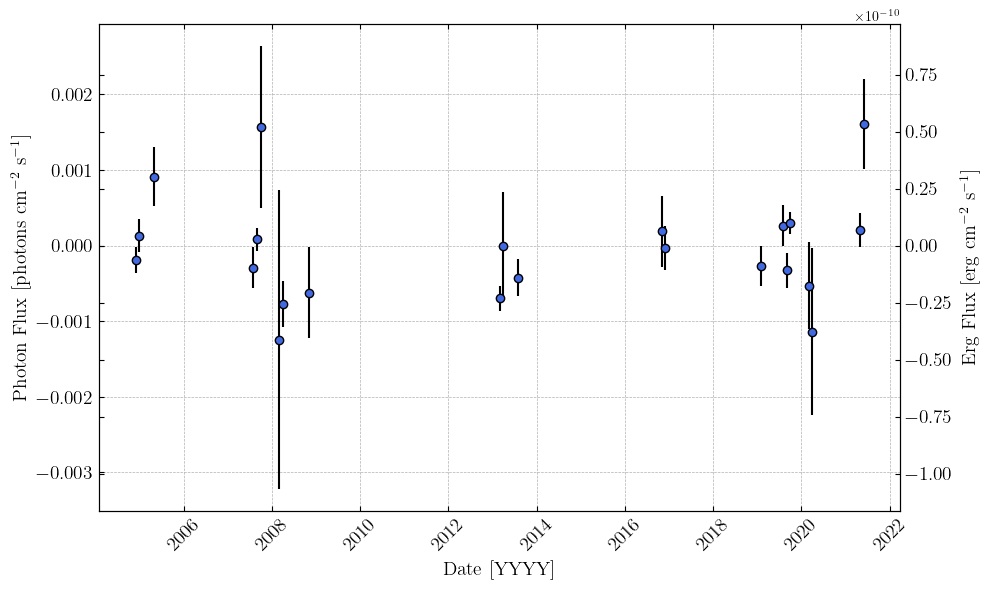

In [39]:
monthly_lightcurve = plot_monthly_flux_lc(ph_flux2, ph_flux2_err, erg_flux2, erg_flux2_err, flux2_date, plot=True)

Comparison with background

Images corresponding to S/N > 3:


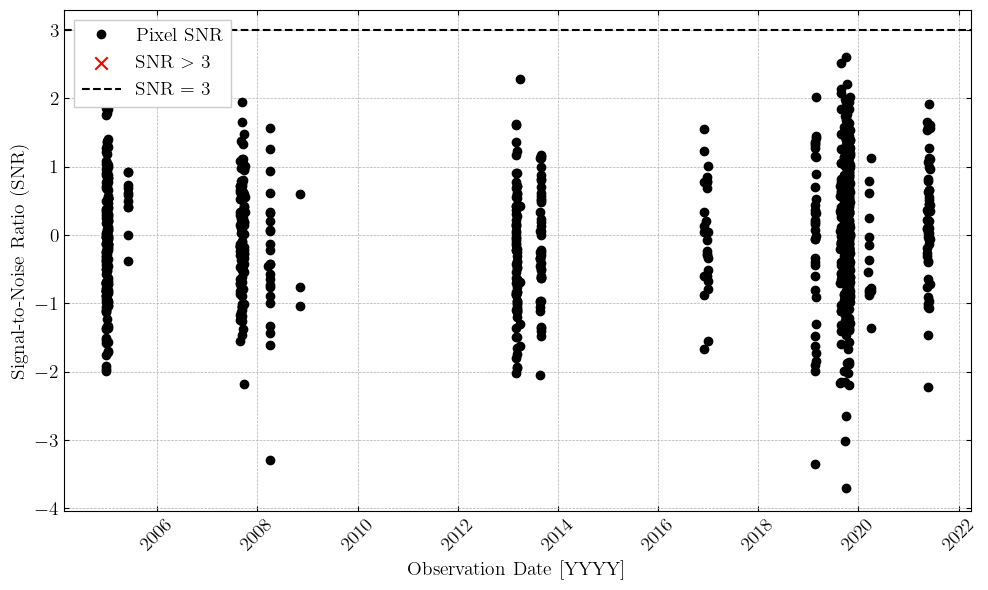

In [40]:
plot_bkgd_snr(img_times2, cr2, vr2, acr2, avr2)

Total points: 915
Observed points |SNR| > 3: 4
Expected points |SNR| > 3: 2.47
Observed fraction: 0.44%
Expected fraction: 0.27%
P-value (|SNR| > 3): 2.360e-01

Observed points SNR > 3: 0
Expected points SNR > 3: 1.24
Observed fraction (positive only): 0.00%
Expected fraction: 0.135%
P-value (SNR > 3): 1.000e+00


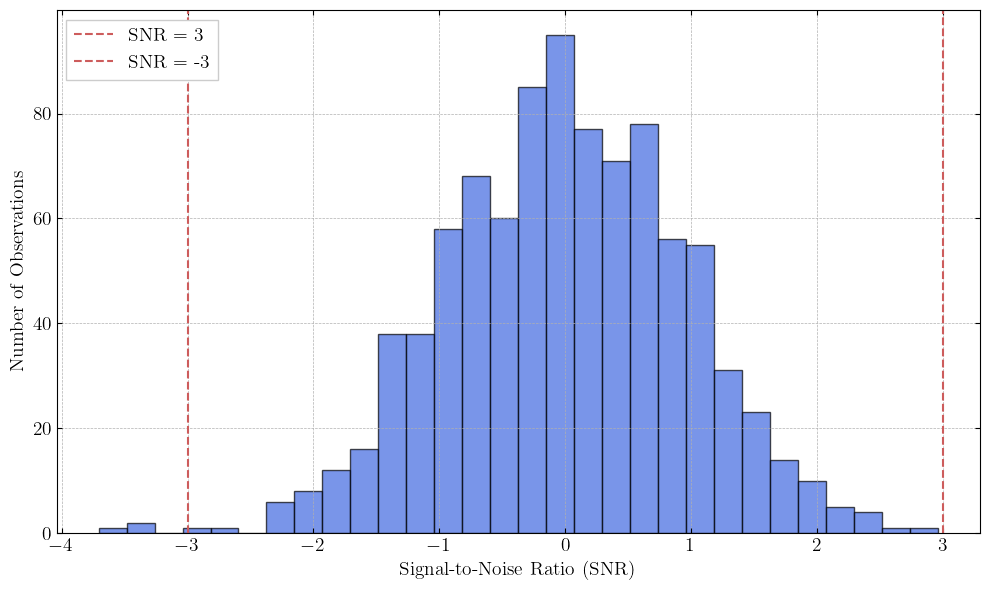

In [41]:
plot_bkgd_snr_distribution(cr2, vr2, acr2, avr2)

### 3 - 15 keV

Light curves

In [43]:
img_times3 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f") for date in date3]

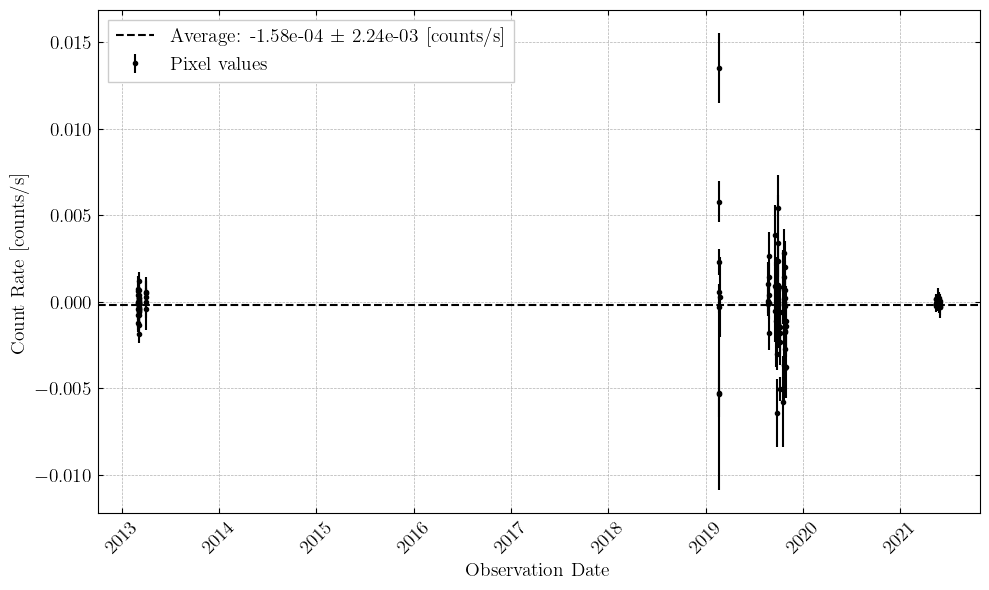

In [44]:
plot_countrate(img_times3, cr3, vr3)

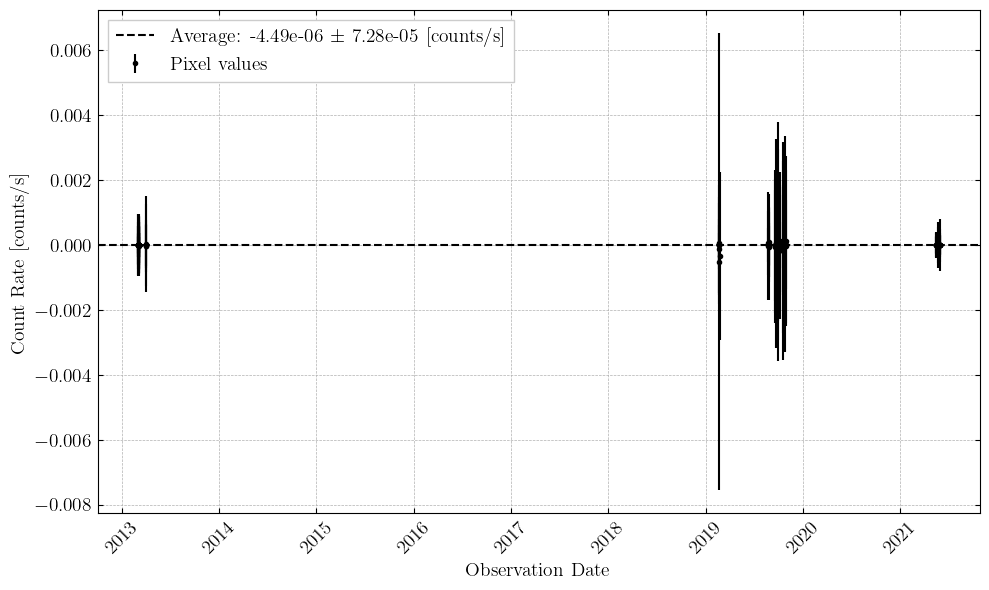

In [45]:
plot_countrate(img_times3, acr3, avr3)

Signal to noise ratio

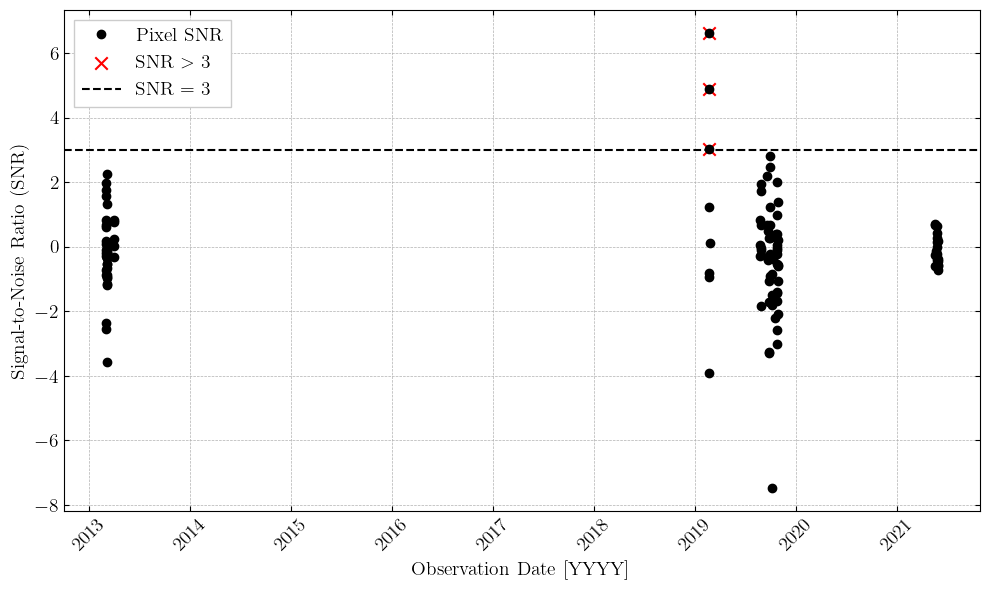

In [46]:
plot_snr(img_times3, cr3, vr3)

Total points: 114
Observed points |SNR| > 3: 8
Expected points |SNR| > 3: 0.31
Observed fraction: 7.02%
Expected fraction: 0.27%
P-value (|SNR| > 3): 1.205e-09

Observed points SNR > 3: 3
Expected points SNR > 3: 0.15
Observed fraction (positive only): 2.63%
Expected fraction: 0.135%
P-value (SNR > 3): 5.289e-04


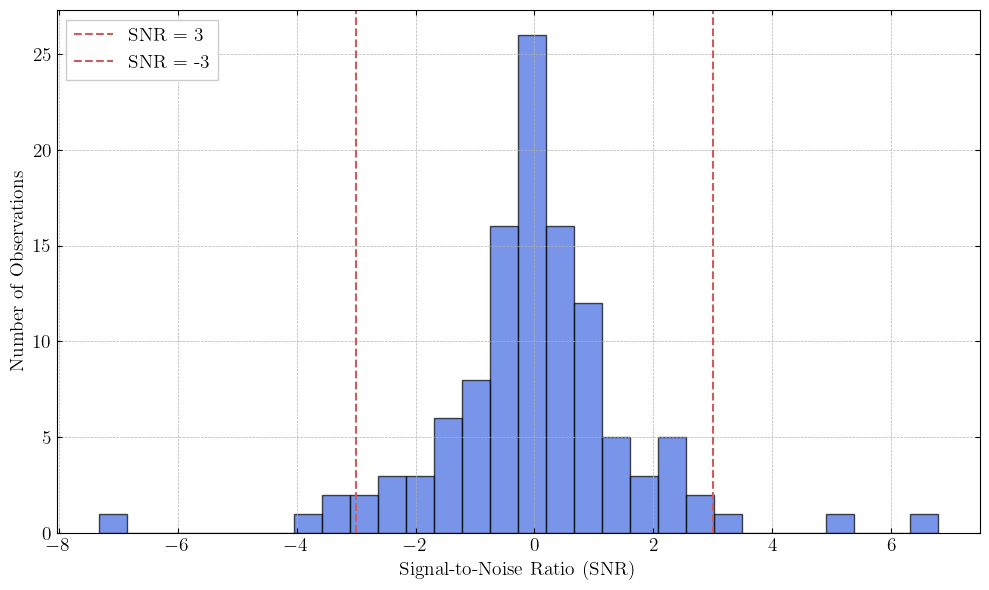

In [47]:
plot_snr_distribution(cr3, vr3, color='royalblue')

Fluxes

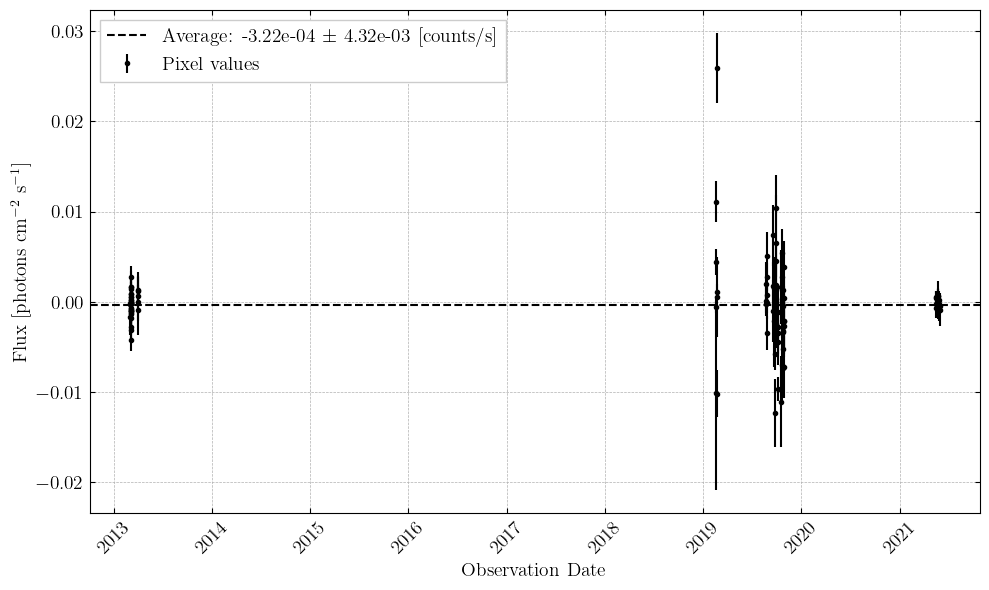

In [48]:
mask = crabENERGY == "3-15 keV"
crabYEAR_3_15 = crabYEAR[mask]
crabCR_3_15 = crabCR[mask]
crabERR_3_15 = crabERR[mask]

ph_flux3, ph_flux3_err, erg_flux3, erg_flux3_err, flux3_date = cr2flux(cr3, vr3, img_times3, crabCR_3_15, crabERR_3_15, crabYEAR_3_15)

plot_flux(flux3_date, ph_flux3, ph_flux3_err**2)

In [49]:
ph_flux_weighted_avg, ph_flux_weighted_err = simple_weighted_average(ph_flux3, ph_flux3_err)
print(f"Weighted Photon Flux: {ph_flux_weighted_avg:.3e} ± {ph_flux_weighted_err:.3e}") 

Weighted Photon Flux: -1.225e-04 ± 1.140e-04


In [50]:
snr = cr3 / np.sqrt(vr3)
outliers_idx = [i for i, snr in enumerate(snr) if snr > 3]

print(f'Persistent upper limit: {ph_flux_weighted_err * 3 + ph_flux_weighted_avg:.3e}') # photons/cm2/s (3 * sigma weighted error + weighted average)
print(f'Average errorbar * 3: {ph_flux1_err.mean() * 3:.3e}') # photons/cm2/s (3 * sigma average error)
print(f'Max upper limit: {np.max([flux for i, flux in enumerate(ph_flux3) if i in outliers_idx]):.3e}') # photons/cm2/s (maximum flux value with S/N > 3)

Persistent upper limit: 2.196e-04
Average errorbar * 3: 6.822e-03
Max upper limit: 2.592e-02


Monthly weighted average

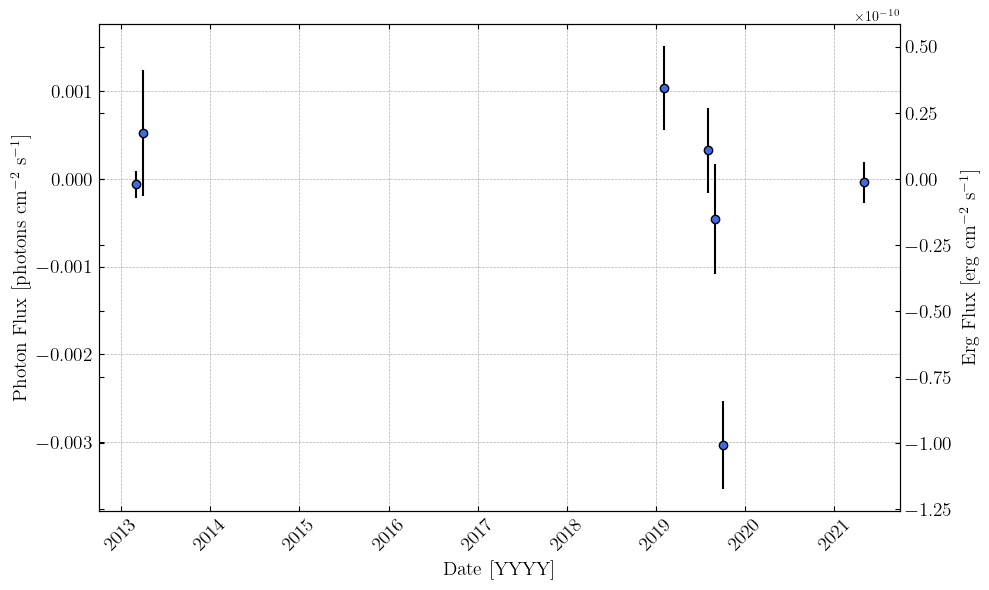

In [53]:
monthly_lightcurve = plot_monthly_flux_lc(ph_flux3, ph_flux3_err, erg_flux3, erg_flux3_err, flux3_date, plot=True)

Comparison with background

Images corresponding to S/N > 3:
Date: 2019-02-20 06:43:12.403000, S/N: 4.904039659398651
File name: 220500170010.001mosaic.fits
Max value: 0.013488407971057112
Index of max value: 43

Date: 2019-02-19 21:34:59.381000, S/N: 3.217938309334908
File name: 214500330010.001mosaic.fits
Max value: 0.013488407971057112
Index of max value: 44



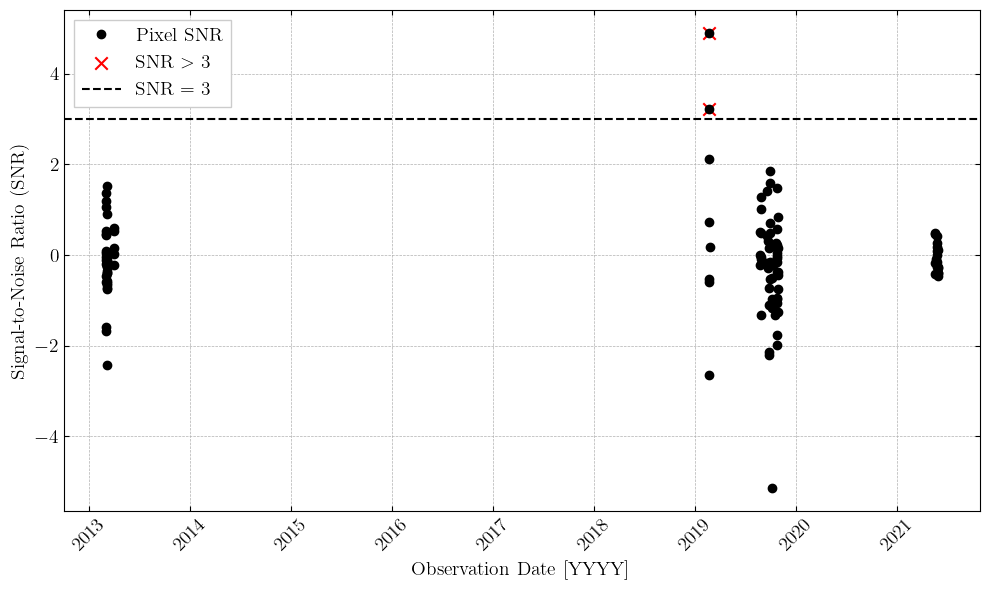

In [54]:
plot_bkgd_snr(img_times3, cr3, vr3, acr3, avr3)

Total points: 114
Observed points |SNR| > 3: 3
Expected points |SNR| > 3: 0.31
Observed fraction: 2.63%
Expected fraction: 0.27%
P-value (|SNR| > 3): 3.786e-03

Observed points SNR > 3: 2
Expected points SNR > 3: 0.15
Observed fraction (positive only): 1.75%
Expected fraction: 0.135%
P-value (SNR > 3): 1.062e-02


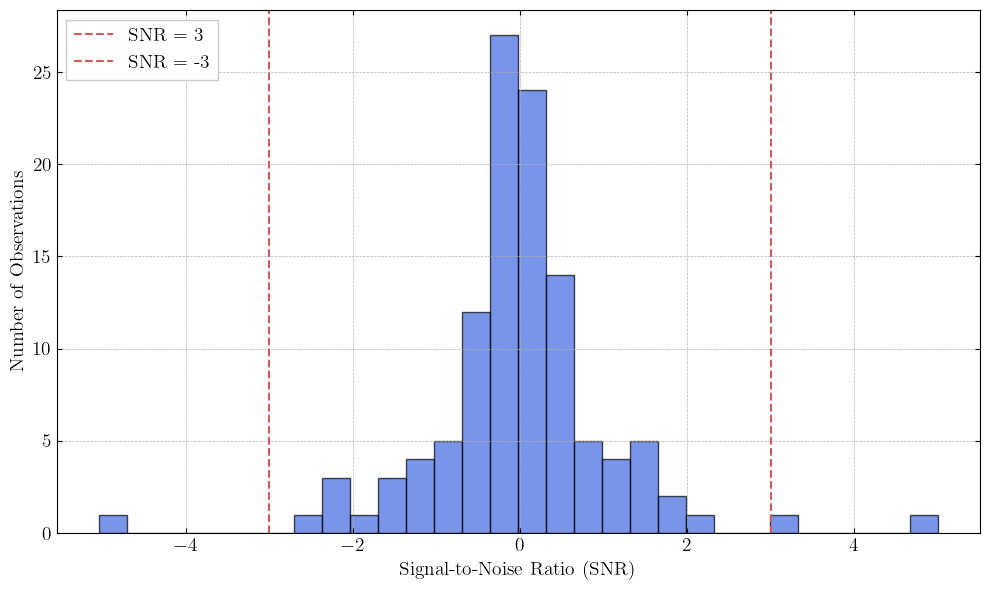

In [55]:
plot_bkgd_snr_distribution(cr3, vr3, acr3, avr3)